# 机器学习毕业项目——猫狗大战

项目源于Kaggle的[Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)比赛

以下所有迭代都能单独运行

In [1]:
# 定义统一处理函数，把长度为n的路径数组转换为维度为（n,224,224,3）的张量
from keras.preprocessing import image
from tqdm import tqdm
def preprocessing(paths):
    def path_to_tensor(path):
        img = image.load_img(path,target_size=(224,224))
        x = image.img_to_array(img)
        return np.expand_dims(x,axis=0)
    
    def paths_to_tensor(paths):
        arr = [path_to_tensor(path) for path in tqdm(paths)]
        return np.vstack(arr)
    
    return paths_to_tensor(paths)

/home/kevin/.conda/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 迭代1——Resnet50迁移，分类器（input-1024-1）

## 数据预处理

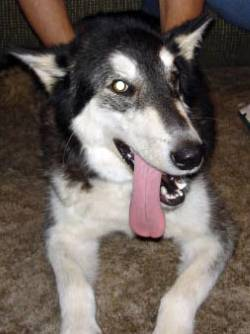

In [1]:
from IPython.display import Image,display
import numpy as np
from glob2 import glob
paths = glob('./data/train_src/*')
Image(np.random.choice(paths))


In [3]:
# 把训练集切分
from sklearn.model_selection import train_test_split
paths = np.array(paths)
cats = paths[['cat' in p for p in paths]]
dogs = paths[['dog' in p for p in paths]]
train_cats, val_cats = train_test_split(cats, test_size=0.1, random_state=1)
train_dogs, val_dogs = train_test_split(dogs, test_size=0.1, random_state=1)

# 把切分后的文件复制到相应文件夹
import os
import shutil

def move_file(src_files, target_path):
    for src_file in src_files:
        _,filename = os.path.split(src_file)
        target_file = target_path + filename
        shutil.copyfile(src_file, target_file)

move_file(train_cats, './data/train/cat/')
move_file(train_dogs, './data/train/dog/')
move_file(val_cats, './data/validate/cat/')
move_file(val_dogs, './data/validate/dog/')

# 验证文件复制
assert len(glob('./data/train/dog/*'))==len(train_dogs)
assert len(glob('./data/train/cat/*'))==len(train_cats)           
assert len(glob('./data/validate/dog/*'))==len(val_dogs)           
assert len(glob('./data/validate/cat/*'))==len(val_cats)           

In [4]:
# 构造训练数据生成器，第一次迭代不做数据增强，配合准备使用的预训练Resnet50做数据缩放
%matplotlib inline
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input

train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=500,
        class_mode='binary')
val_generator = val_datagen.flow_from_directory(
        'data/validate',
        target_size=(224, 224),
        batch_size=500,
        class_mode='binary')

# train_generator.next()[0]

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


一开始，在数据预处理中最大的困惑在于：一次性加载所有数据会引发MemoryError,如何实现分批加载数据？  
知道用ImageDataGenerator后，如何使用生成器成了一个大难题，后来得知主要要解决目录结构问题。

## 模型搭建

In [5]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential, Model

# 构造模型
model1 = Sequential()
model1.add(Flatten(input_shape=(1,1,2048)))
model1.add(Dense(1024,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.summary()
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 构造训练数据（为了避免预训练模型与生成器的融合问题，因此先用生成器生成数据然后用预训练模型做预处理）
from keras.applications import ResNet50
pretrain_model = ResNet50(weights='./model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False)

train_x, train_y = None,None
val_x, val_y = None,None

init = False
for _ in tqdm(range(45)):
    x, y = train_generator.next()
    x = pretrain_model.predict(x)
    train_x = x if not init else np.concatenate((train_x,x),axis=0)
    train_y = y if not init else np.concatenate((train_y,y),axis=0)
    init = True

init = False
for _ in tqdm(range(5)):
    x, y = val_generator.next()
    x = pretrain_model.predict(x)
    val_x = x if not init else np.concatenate((val_x,x),axis=0)
    val_y = y if not init else np.concatenate((val_y,y),axis=0)
    init = True



100%|██████████| 5/5 [00:49<00:00,  9.98s/it]


In [7]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='./model/saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)


model1.fit(train_x,train_y, validation_data=(val_x,val_y), epochs=10, batch_size=50, verbose=1, callbacks=[checkpointer])


Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22450/22500 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9804
Epoch 00001: val_loss improved from inf to 0.05401, saving model to ./model/saved_models/weights.best.Resnet50.hdf5
22500/22500 [==============================] - 5s 203us/step - loss: 0.0589 - acc: 0.9803 - val_loss: 0.0540 - val_acc: 0.9824
Epoch 2/10
22350/22500 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9894
Epoch 00002: val_loss improved from 0.05401 to 0.03414, saving model to ./model/saved_models/weights.best.Resnet50.hdf5
22500/22500 [==============================] - 3s 151us/step - loss: 0.0285 - acc: 0.9893 - val_loss: 0.0341 - val_acc: 0.9880
Epoch 3/10
22400/22500 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9917
Epoch 00003: val_loss improved from 0.03414 to 0.03389, saving model to ./model/saved_models/weights.best.Resnet50.hdf5
22500/22500 [==============================] - 3s 149us/

在模型搭建中，最大的困惑在于使用图片生成器与预训练模型时，如何把这两者结合在一起？

## 模型结果验证

In [8]:
import pandas as pd

def get_test_data():
    paths = []
    for i in range(1,12501):
        p = './data/test/{}.jpg'.format(i)
        paths.append(p)
    # 加载测试数据
    return pretrain_model.predict(preprocess_input(preprocessing(paths)))

def model_predict():
    model1.load_weights('./model/saved_models/weights.best.Resnet50.hdf5')
    return model1.predict(get_test_data())

pred = model_predict()


100%|██████████| 12500/12500 [00:31<00:00, 393.23it/s]


In [16]:
pred = pred.clip(0.005,0.995)
rs = pd.DataFrame(pred,columns=['label'])
rs['id'] = range(1,12501)
rs.to_csv('./data/model1_naive.csv',index=False)

,label,id
0,0.995000,1
1,0.995000,2
2,0.995000,3
3,0.995000,4
4,0.005000,5
5,0.005000,6
6,0.005000,7
7,0.005000,8
8,0.005000,9
9,0.005000,10


In [15]:
model1.evaluate(val_x,val_y,verbose=1)

2500/2500 [==============================] - 1s 252us/step


[0.03388661728756197, 0.9872]

**迭代1最终测试集预测分数为0.05238**

# 迭代2——迭代1 + 数据增强

## 数据预处理

In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing import image
from glob2 import glob
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input
from IPython.display import display,Image

In [3]:
def show_augmentation(datagen):
    generator = datagen.flow_from_directory(
            'data/image_demo',
            shuffle=False,
            target_size=(224, 224),
            batch_size=6,
            class_mode='binary')
    fig = plt.figure(figsize=(15,15))
    pics = generator.next()[0]
    for i in range(6):
        img = pics[i]
        sub_img = fig.add_subplot(331+i)
        sub_img.imshow(img)
    plt.show()


Found 6 images belonging to 2 classes.


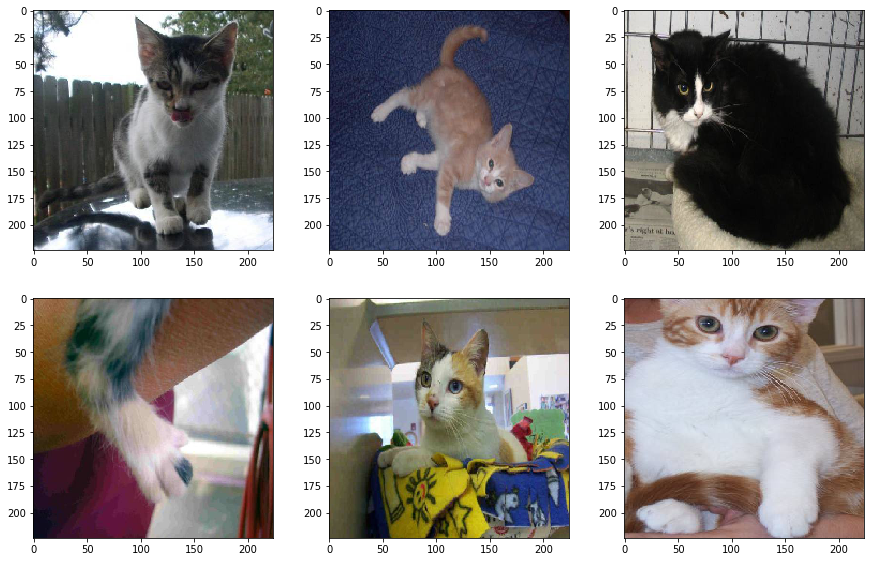

In [4]:
datagen = image.ImageDataGenerator(rescale=1/255)
show_augmentation(datagen)

Found 6 images belonging to 2 classes.


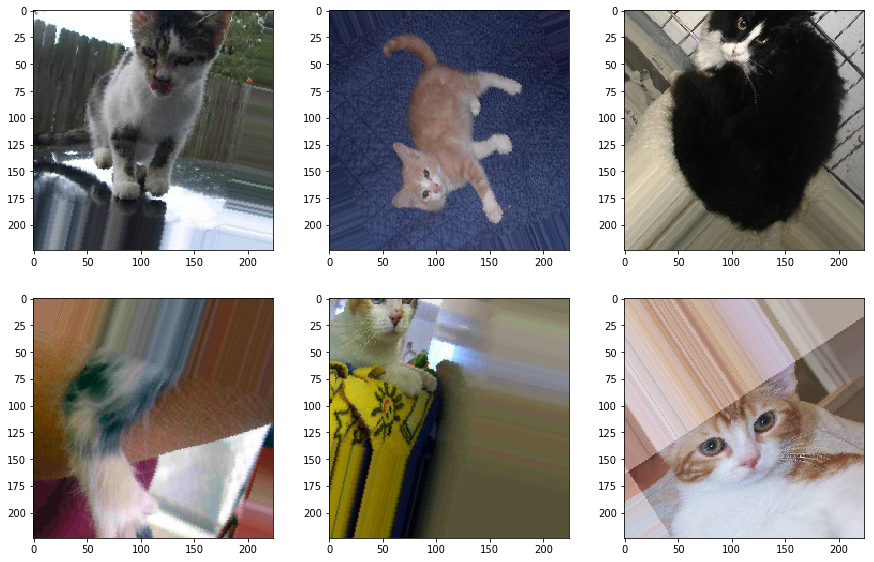

In [5]:
datagen = image.ImageDataGenerator(rescale=1/255,rotation_range=45,horizontal_flip=True, vertical_flip=True,width_shift_range=0.4,height_shift_range=0.4)
show_augmentation(datagen)

Found 6 images belonging to 2 classes.


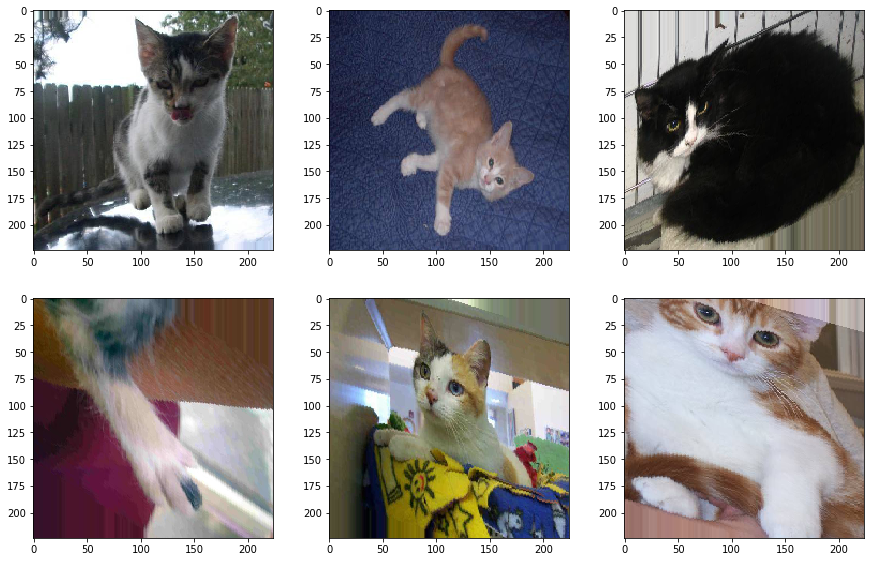

In [6]:
datagen = image.ImageDataGenerator(rescale=1/255,shear_range=45)
show_augmentation(datagen)

Found 6 images belonging to 2 classes.


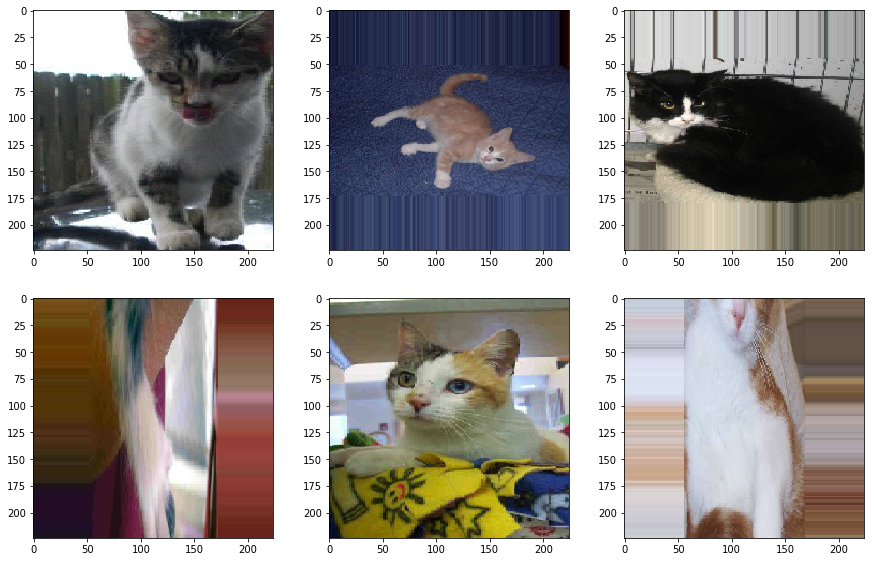

In [7]:
datagen = image.ImageDataGenerator(rescale=1/255,zoom_range=[0.5,2])
show_augmentation(datagen) 

Found 6 images belonging to 2 classes.


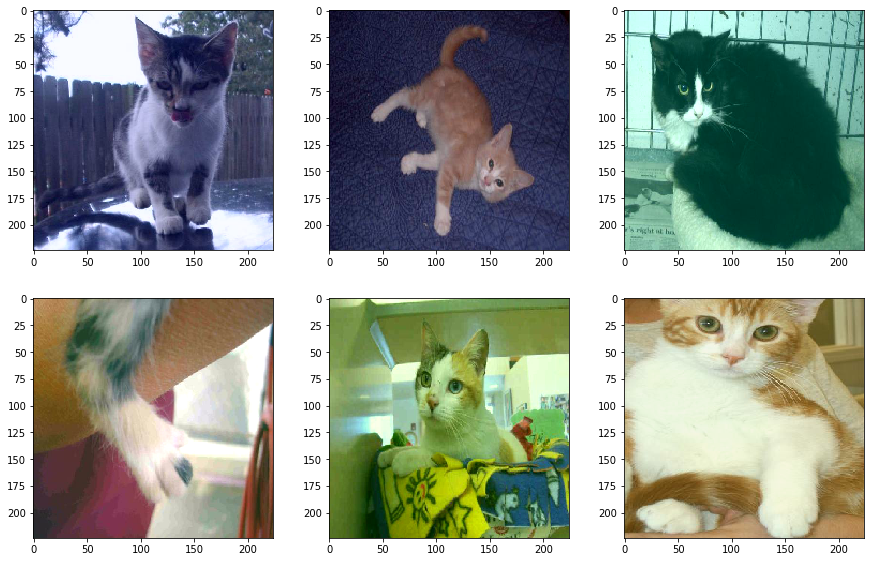

In [10]:
datagen = image.ImageDataGenerator(rescale=1/255,channel_shift_range=50)
show_augmentation(datagen) 

In [24]:
# 定义生成器
from keras.applications.resnet50 import preprocess_input

comb_datagen = image.ImageDataGenerator(
    shear_range=45,
    preprocessing_function=preprocess_input,
    zoom_range=[0.5,2],
    rotation_range=45,
    horizontal_flip=True, 
    vertical_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4,
    channel_shift_range=200)

aug_generator = comb_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=500,
        class_mode='binary')

Found 22500 images belonging to 2 classes.


In [25]:
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=500,
        class_mode='binary')
val_generator = val_datagen.flow_from_directory(
        'data/validate',
        target_size=(224, 224),
        batch_size=500,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 模型搭建

In [26]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential, Model

# 构造模型
model1 = Sequential()
model1.add(Flatten(input_shape=(1,1,2048)))
model1.add(Dense(1024,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.summary()
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 构造训练数据（为了避免预训练模型与生成器的融合问题，因此先用生成器生成数据然后用预训练模型做预处理）
from keras.applications import ResNet50
from tqdm import tqdm
pretrain_model = ResNet50(weights='./model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False)

train_x, train_y = None,None
val_x, val_y = None,None

init = False
for i in tqdm(range(100)):
    x, y = None, None
    if i<50:
        x, y = train_generator.next()
        x = pretrain_model.predict(x)
    else:
        x, y = aug_generator.next()
        x = pretrain_model.predict(x)
    train_x = x if not init else np.concatenate((train_x,x),axis=0)
    train_y = y if not init else np.concatenate((train_y,y),axis=0)
    init = True

init = False
for _ in tqdm(range(5)):
    x, y = val_generator.next()
    x = pretrain_model.predict(x)
    val_x = x if not init else np.concatenate((val_x,x),axis=0)
    val_y = y if not init else np.concatenate((val_y,y),axis=0)
    init = True

100%|██████████| 5/5 [00:52<00:00, 10.48s/it]


In [ ]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='./model/saved_models/weights.best2.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)


model1.fit(train_x,train_y, validation_data=(val_x,val_y), epochs=10, batch_size=50, verbose=1, callbacks=[checkpointer])


Train on 50000 samples, validate on 2500 samples
Epoch 1/10
49900/50000 [============================>.] - ETA: 0s - loss: 0.2860 - acc: 0.8647
Epoch 00001: val_loss improved from inf to 0.03568, saving model to ./model/saved_models/weights.best2.Resnet50.hdf5
50000/50000 [==============================] - 11s 224us/step - loss: 0.2859 - acc: 0.8647 - val_loss: 0.0357 - val_acc: 0.9888
Epoch 2/10
49650/50000 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.8881
Epoch 00002: val_loss improved from 0.03568 to 0.03541, saving model to ./model/saved_models/weights.best2.Resnet50.hdf5
50000/50000 [==============================] - 8s 169us/step - loss: 0.2328 - acc: 0.8881 - val_loss: 0.0354 - val_acc: 0.9864
Epoch 3/10
49700/50000 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.8971
Epoch 00003: val_loss did not improve
50000/50000 [==============================] - 8s 169us/step - loss: 0.2182 - acc: 0.8969 - val_loss: 0.0364 - val_acc: 0.9848
Epoch 4/

## 模型验证

In [ ]:
import pandas as pd

def get_test_data():
    paths = []
    for i in range(1,12501):
        p = './data/test/{}.jpg'.format(i)
        paths.append(p)
    # 加载测试数据
    return pretrain_model.predict(preprocess_input(preprocessing(paths)))

def model_predict():
    model1.load_weights('./model/saved_models/weights.best2.Resnet50.hdf5')
    return model1.predict(get_test_data())

pred = model_predict()

100%|██████████| 12500/12500 [00:34<00:00, 359.82it/s]


In [23]:
pred = pred.clip(0.005,0.995)
rs = pd.DataFrame(pred,columns=['label'])
rs['id'] = range(1,12501)
rs.to_csv('./data/model1_raw_augmented.csv',index=False)